In [8]:
pip install --upgrade mxnet~=1.7 gluonts

In [2]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
# gluon datasets
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [5]:
pip install mxnet

In [6]:
dataset_nasa = pd.read_csv('DOE-551-600-10DU-01_1.csv')

In [7]:
dataset_nasa


,index,Test_Time,Step_Time(s),Cycle_Index,Step_Index,Voltage,Test_Time(s),Step_Time(s).1,Cycle_Index.1,Step_Index.1,Current,Test_Time(s).1,Step_Time(s).2,Cycle_Index.2,Step_Index.2,Charge_Capacity,Test_Time(s).2,Step_Time(s).3,Cycle_Index.3,Step_Index.3,Discharge_Capacity
0,0,120.001100,120.0010,1,1,3.575560,120.001100,120.0010,1,1,0.000000,120.001100,120.0010,1,1,0.000000,120.001100,120.0010,1,1,0.000000
1,1,240.004000,240.0039,1,1,3.575512,240.004000,240.0039,1,1,0.000000,240.004000,240.0039,1,1,0.000000,240.004000,240.0039,1,1,0.000000
2,2,360.002300,360.0022,1,1,3.577263,360.002300,360.0022,1,1,0.000000,360.002300,360.0022,1,1,0.000000,360.002300,360.0022,1,1,0.000000
3,3,480.004900,480.0048,1,1,3.578959,480.004900,480.0048,1,1,0.000000,480.004900,480.0048,1,1,0.000000,480.004900,480.0048,1,1,0.000000
4,4,600.005800,600.0057,1,1,3.579659,600.005800,600.0057,1,1,0.000000,600.005800,600.0057,1,1,0.000000,600.005800,600.0057,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,3976,461127.552312,120.0001,50,6,3.611401,461127.552312,120.0001,50,6,0.000000,461127.552312,120.0001,50,6,2.450970,461127.552312,120.0001,50,6,2.449697
3977,3977,461247.553112,240.0009,50,6,3.644613,461247.553112,240.0009,50,6,0.000000,461247.553112,240.0009,50,6,2.450970,461247.553112,240.0009,50,6,2.449697
3978,3978,461307.554012,300.0018,50,6,3.652942,461307.554012,300.0018,50,6,0.000000,461307.554012,300.0018,50,6,2.450970,461307.554012,300.0018,50,6,2.449697
3979,3979,461427.643156,120.0016,51,8,4.190305,461427.643156,120.0016,51,8,3.260095,461427.643156,120.0016,51,8,0.108668,461427.643156,120.0016,51,8,0.000000


In [9]:
df = pd.DataFrame(dataset_nasa)
cols = [0,20]
df = df[df.columns[cols]]

In [10]:
df

,index,Discharge_Capacity
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
3976,3976,2.449697
3977,3977,2.449697
3978,3978,2.449697
3979,3979,0.000000


In [11]:
df1 = df.to_numpy()

In [12]:
train_size = int(len(df1)*0.8)
test_size = len(df1) - train_size
train = df1[1:train_size,:]
test = df1[train_size:len(df1)]

In [13]:
train_size

3184

In [14]:
train_set = pd.DataFrame(train)

In [15]:
train_set

,0,1
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.000000
3,4.0,0.000000
4,5.0,0.000000
...,...,...
3178,3179.0,2.053876
3179,3180.0,2.129921
3180,3181.0,2.206009
3181,3182.0,2.282089


In [16]:
test_set = pd.DataFrame(test)

In [17]:
test_set

,0,1
0,3184.0,2.434215
1,3185.0,2.454405
2,3186.0,2.454449
3,3187.0,2.454449
4,3188.0,2.454449
...,...,...
792,3976.0,2.449697
793,3977.0,2.449697
794,3978.0,2.449697
795,3979.0,0.000000


In [18]:
df.columns

Index(['index', 'Discharge_Capacity'], dtype='object')

In [19]:
df_input = df[['index','Discharge_Capacity']]

In [20]:
df_input = df_input.set_index('index')

In [21]:
train_time = 949
prediction_length = 949
freq = "2min"

In [22]:
from gluonts.dataset.common import ListDataset
train_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Discharge_Capacity[:train_time] }],
    freq = "2min"
)

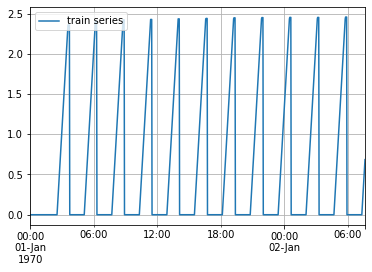

In [23]:
entry = next(iter(train_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.savefig("fig1.pdf",bbox_inches="tight")
plt.show()

In [25]:
test_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Discharge_Capacity[:]}],
    freq = "2min"
)

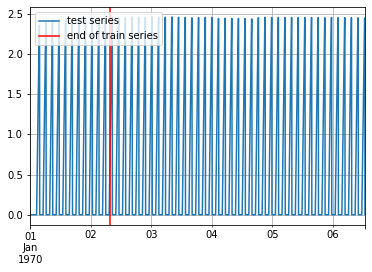

In [26]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show()

In [27]:
print(f"Length of forecasting window in test dataset:{len(test_series)-len(train_series)}")
print(f"Frequency of the time series:{freq}")

Length of forecasting window in test dataset:3032
Frequency of the time series:2min


In [28]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

In [29]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=250,
    context_length=50,
    freq="2min",
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [30]:
predictor = estimator.train(train_data)

100%|██████████| 100/100 [00:01<00:00, 81.34it/s, epoch=5/5, avg_epoch_loss=-.385]


In [31]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [32]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation 100
)

In [33]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [34]:
# first entry of the time series list
ts_entry = tss[0]

In [35]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0., 0., 0., 0., 0.], dtype=float32)

In [36]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_data))

In [37]:
# first 5 values
dataset_test_entry['target'][:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [38]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [39]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 500
Dimension of samples: (500, 250)
Start date of the forecast window: 1970-01-06 04:22:00
Frequency of the time series: 2min


In [40]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 2.05205536e+00  1.95103049e+00  2.08023024e+00  2.27497554e+00
  1.96389925e+00  1.60142708e+00  1.00121415e+00  1.07020509e+00
  3.98331821e-01  2.64648318e-01  9.79315519e-01  2.76391834e-01
 -2.24537775e-02  1.71252340e-01  8.89422148e-02  1.02998510e-01
  8.38429332e-02  1.52294263e-02  1.08401608e-02  2.57823486e-02
 -4.77167889e-02  1.67815927e-02  2.29330771e-02  2.13811528e-02
  6.17569080e-03  1.61084346e-02 -1.82502791e-02 -1.37526705e-03
  1.04577572e-03 -5.76140359e-03  1.63273551e-02  1.63255855e-02
  2.25790553e-02 -1.14495039e-03 -1.48807280e-03  2.07823073e-03
 -1.28919641e-02 -2.24432582e-03 -1.15615753e-02  1.63501967e-02
  1.17916390e-02 -8.15833174e-03  1.24645904e-02 -3.70196113e-03
 -3.38650099e-03  1.50257517e-02  6.45495253e-03  1.85807198e-02
 -1.17190816e-02 -7.79392198e-03  1.19092334e-02  1.95462015e-02
  2.58682277e-02  7.49498382e-02  1.35908484e-01  2.04426080e-01
  2.99203187e-01  3.57280403e-01  4.54792619e-01  5.07333457e-

In [41]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig3.pdf",bbox_inches="tight")
    plt.show()

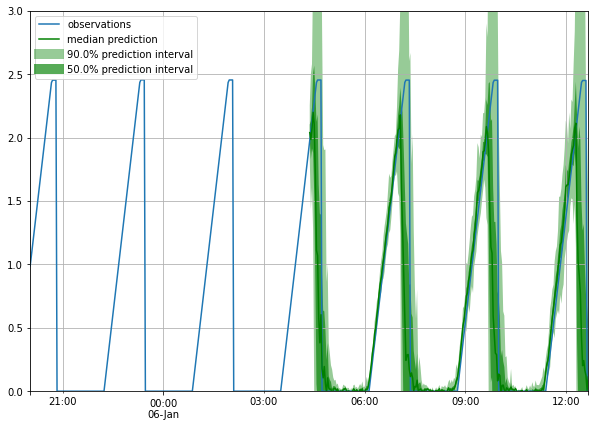

In [42]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [43]:
from gluonts.evaluation import Evaluator

In [44]:
evaluator = Evaluator(quantiles=[0.5,0.1,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


In [45]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.41828326416015627,
    "abs_error": 64.24183654785156,
    "abs_target_sum": 175.16659545898438,
    "abs_target_mean": 0.7006663818359375,
    "seasonal_error": 0.5423285599286989,
    "MASE": 0.47382226417356726,
    "MAPE": 72039126.91358025,
    "sMAPE": 1.240461181640625,
    "MSIS": 3.822784251667603,
    "QuantileLoss[0.5]": 64.24184390027222,
    "Coverage[0.5]": 0.712,
    "QuantileLoss[0.1]": 32.278181137568026,
    "Coverage[0.1]": 0.124,
    "QuantileLoss[0.9]": 19.458182475587815,
    "Coverage[0.9]": 0.948,
    "RMSE": 0.6467482231596436,
    "NRMSE": 0.9230473159922222,
    "ND": 0.3667470751459226,
    "wQuantileLoss[0.5]": 0.36674711711979685,
    "wQuantileLoss[0.1]": 0.1842713278350268,
    "wQuantileLoss[0.9]": 0.11108386518903365,
    "mean_absolute_QuantileLoss": 38.65940250447602,
    "mean_wQuantileLoss": 0.22070077004795244,
    "MAE_Coverage": 0.09466666666666664,
    "OWA": NaN
}


In [46]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.418283,64.241837,175.166595,0.700666,0.542329,0.473822,7.203913e+07,1.240461,3.822784,64.241844,0.712,32.278181,0.124,19.458182,0.948


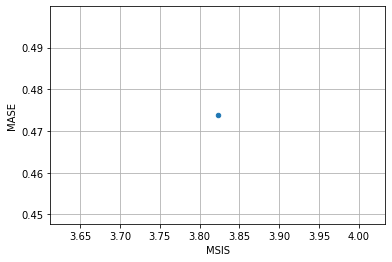

In [47]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig4.pdf",bbox_inches="tight")
plt.show()

In [48]:
# own forecast model

In [49]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='relu'))


class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [50]:
def plot_prob_forecasts_2(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig5.pdf",bbox_inches="tight")
    plt.show()

In [51]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import as_in_context, batchify
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import copy_parameters, get_hybrid_forward_input_names
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [52]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [53]:

# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 1901,
    'prediction_length': 100,
    'freq': '2min',
    'start': [
        pd.Timestamp("01-01-2019", freq='2min')
        for _ in range(100)
    ]
}

In [114]:
estimator = MyEstimator(
    prediction_length=250,     #custom_ds_metadata['prediction_length'],
    context_length = custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=30, #40
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=2000
    )
)

In [115]:
from gluonts.dataset.field_names import FieldName
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [116]:
predictor = estimator.train(train_data)

100%|██████████| 2000/2000 [00:35<00:00, 56.69it/s, epoch=5/5, avg_epoch_loss=0.149]


In [117]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [118]:
forecasts = list(forecast_it)
tss = list(ts_it)

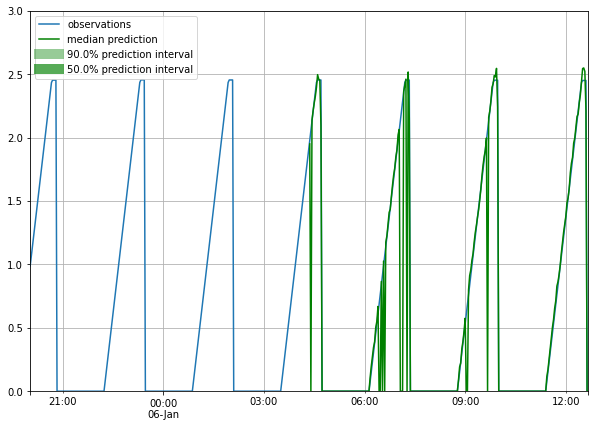

In [119]:
plot_prob_forecasts_2(tss[0], forecasts[0])

In [120]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


In [121]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.13344940185546875,
    "abs_error": 21.923431396484375,
    "abs_target_sum": 175.16659545898438,
    "abs_target_mean": 0.7006663818359375,
    "seasonal_error": 0.5423285599286989,
    "MASE": 0.1616985201691513,
    "MAPE": 0.37095227653597607,
    "sMAPE": 0.7163187038679064,
    "MSIS": 6.467940356594988,
    "QuantileLoss[0.1]": 8.650530783143891,
    "Coverage[0.1]": 0.348,
    "QuantileLoss[0.5]": 21.923429567651215,
    "Coverage[0.5]": 0.348,
    "QuantileLoss[0.9]": 35.19632835215855,
    "Coverage[0.9]": 0.348,
    "RMSE": 0.3653072704662046,
    "NRMSE": 0.5213711973864076,
    "ND": 0.1251576040456743,
    "wQuantileLoss[0.1]": 0.049384591625344636,
    "wQuantileLoss[0.5]": 0.1251575936051382,
    "wQuantileLoss[0.9]": 0.20093059558493187,
    "mean_absolute_QuantileLoss": 21.923429567651215,
    "mean_wQuantileLoss": 0.12515759360513823,
    "MAE_Coverage": 0.31733333333333336,
    "OWA": NaN
}


In [122]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.133449,21.923431,175.166595,0.700666,0.542329,0.161699,0.370952,0.716319,6.46794,8.650531,0.348,21.92343,0.348,35.196328,0.348


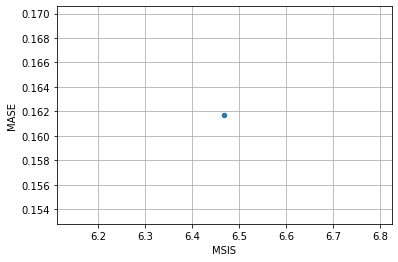

In [123]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig6.pdf",bbox_inches="tight")
plt.show()